In [2]:
source('source.r')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


# Diurnal Signal Module

In [12]:
load(file='./RStates/ship.ncp.2min.rdata')

#dd = sqrt((ship.data$LA - ship.data$Drifter.lat)^2 + (ship.data$LO - ship.data$Drifter.lon)^2)
#l = which(dd < 6/65)
#ship.data = ship.data[l,]

#ship.data$NCP.EIMS = runmed(ship.data$NCP.EIMS, 15)
#ship.data$NCP.MIMS = runmed(ship.data$NCP.MIMS, 15)

In [83]:
plot.diurnal = function(cycle, max.distance = 5, ylim=c(-0.1, 0.4)) {
    l.other = which(ship.data$Cycle == cycle & ship.data$EIMS.O2.Ar.FLAG == 1 & ship.data$MIMS.O2.Ar.FLAG == 1)
    l.eims = which(ship.data$Cycle == cycle & ship.data$EIMS.O2.Ar.FLAG == 1 &
                   ship.data$Dist.to.Drifter < max.distance)
    l.mims = which(ship.data$Cycle == cycle & ship.data$MIMS.O2.Ar.FLAG == 1 &
                   ship.data$Dist.to.Drifter < max.distance)

    plot(ship.data$DT[l.eims], ship.data$BOS.EIMS[l.eims], pch=16, cex=0.5, ylim=ylim, main=cycle,
        ylab='NCP (mmol O2 m-2 d-1)', xlab='')
    
    points(ship.data$DT[l.mims], ship.data$BOS.MIMS[l.mims], pch=16, cex=0.5, col='red')
    points(ship.data$DT[l.other], ship.data$BOS.MIMS[l.other], pch=16, cex=0.5, col='#aa000010')
    points(ship.data$DT[l.other], ship.data$BOS.EIMS[l.other], pch=16, cex=0.5, col='#11111110')
    
    ## Add PAR
    points(ship.data$DT, ship.data$PA/30000+0.25, pch=20, cex=0.4, col='grey')
    axis(4, at = c(0.25, 0.35), labels = c(0, 3000),
         col.ticks = 'dark grey', col.axis='dark grey', las=1)
    
    ## Add Wind
    points(ship.data$DT, ship.data$NCEP*0.01+0.25, pch=20, cex=0.1, col='#0000ff05')
    axis(2, at = c(0.25, 0.35), labels = c(0, 10), col='blue', las=1, col.axis='blue')
    lines(c(min(ship.data$DT[l.eims]), max(ship.data$DT[l.eims])), rep(0.25,2), col='blue', lty = 2)
    
    ## Add ship fluorometer
    points(ship.data$DT, ship.data$FL/100-0.1, col='green', pch=8, cex=0.1)
    axis(4, at = c(-0.1, 0), labels = c(0, 10),
         col.ticks = 'green', col.axis='green', las=1)
    
    add.daynight()
}

In [85]:
pdf('Output/Module Diurnal - Cycle 1 2.pdf')

#par(mfrow=c(2,2))

plot.diurnal('Cycle1')
plot.diurnal('Cycle2')
plot.diurnal('Cycle3')
plot.diurnal('Cycle4')

dev.off()

png 
  2

In [62]:
plot.diurnal2 = function(cycle, max.distance = 5, ylim=c(-50, 150)) {
    l.other = which(ship.data$Cycle == cycle & ship.data$EIMS.O2.Ar.FLAG == 1 & ship.data$MIMS.O2.Ar.FLAG == 1)
    l.eims = which(ship.data$Cycle == cycle & ship.data$EIMS.O2.Ar.FLAG == 1 &
                   ship.data$Dist.to.Drifter < max.distance)
    l.mims = which(ship.data$Cycle == cycle & ship.data$MIMS.O2.Ar.FLAG == 1 &
                   ship.data$Dist.to.Drifter < max.distance)

    plot(ship.data$DT[l.eims], ship.data$NCP.EIMS[l.eims], pch=16, cex=0.5, ylim=ylim, main=paste('EIMS -',cycle),
        ylab='NCP (mmol O2 m-2 d-1)', xlab='')
    
    low = lowess(ship.data$DT[l.eims], ship.data$NCP.EIMS[l.eims], f=0.04)
    lines(low, lwd=2, col='blue')
    #lines(ship.data$DT[l.eims], ma(ship.data$NCP.EIMS[l.eims], 21), lwd=2, col='blue')
    add.daynight()
    
    #### MIMS
    plot(ship.data$DT[l.mims], ship.data$NCP.MIMS[l.mims], pch=16, cex=0.5, ylim=ylim, main=paste('MIMS -',cycle),
        ylab='NCP (mmol O2 m-2 d-1)', xlab='', col='red')
    
    low = lowess(ship.data$DT[l.mims], ship.data$NCP.MIMS[l.mims], f = 0.04)
    lines(low, lwd=2, col='blue')
    
    add.daynight()
}

In [134]:
#par(mfrow=c(2,1))
#plot.diurnal2('Cycle1')

# GPP

In [100]:
load('RStates/CTD.pos.rdata')
load('RStates/ship.final.2min.rdata')

In [88]:
summary(ctd$Trans)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  65.88   98.81   99.43   98.68   99.68   99.92 

In [101]:
get.ship = function(time) {
    dt = as.numeric(difftime(time, ship.data$DT, units = 'days'))
    l = which(dt >= 0 & dt < 1)
    ship.data[l,]
}

calculate.gpp = function(time) {
    ## Load FRRF data
    fit = load.frrf(time)
    #ctd = get.ctd(time)
    
    ## Get ship.data
    ship = get.ship(time)
    mld = median(ship$MLD, na.rm = TRUE)
    
    trans = 0.94
    
    GPP = 0
    delta.d = 1
    
    for (t in 2:nrow(ship)) {
        for (i in seq(0, mld, delta.d)) {
            light = ship$PA[t] * (trans ^ i)^2
            j = which.min(abs(fit$pred$x - light))
            jvp = fit$pred$y[j]
            GPP = GPP + jvp * delta.d / (4 * 1.4) * as.numeric(difftime(ship$DT[t], ship$DT[t-1], units = 'sec'))
        }
    }
    if(length(GPP) < 1) {
        return(0)
    }
    GPP
}

In [102]:
frrf.path = 'RStates/FRRF/'
frrf.files = list.files(path = 'RStates/FRRF')

frrf.times = lapply(frrf.files,
                    function(x) {
                        as.POSIXct(as.numeric(strsplit(x, '.rdata')[[1]]), origin="1970-01-01", tz = 'GMT')
                    }
                   )



load.frrf = function(time) {
    dt = abs(as.numeric(frrf.times) - as.numeric(time))
    i = which.min(dt)
    load(paste0(frrf.path, frrf.files[i]))
    
    fit
}

get.ctd = function(time) {
    dt = abs(as.numeric(difftime(ctd.times), time, unit='hours'))
    i = which.min(dt)
    
    ctd[which(ctd$Cast == ctd.casts[i]),]
}

In [ ]:
ship.data$GPP = 0

for (i in 1:nrow(ship.data)) {
    ship.data$GPP[i] = calculate.gpp(ship.data$DT[i])
}


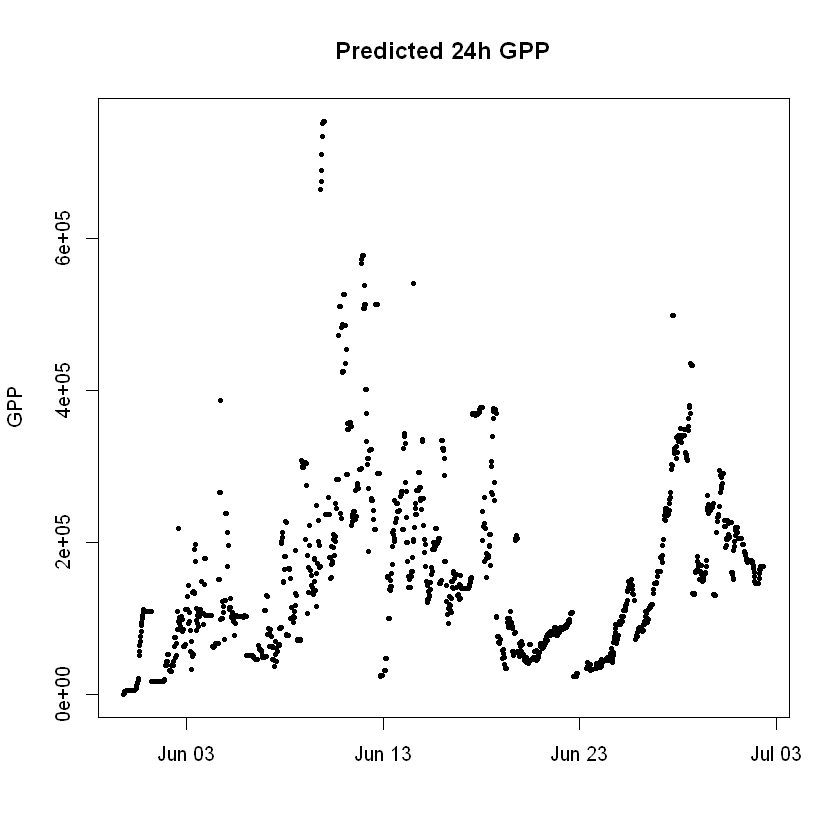

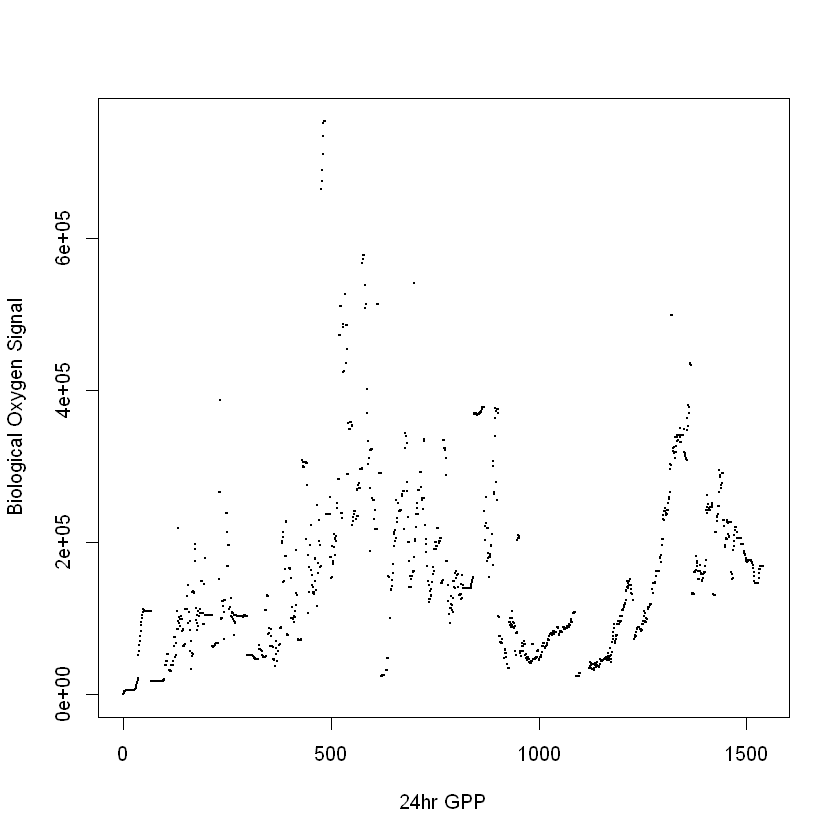

In [99]:
#png('Output/Diurnal Module - GPP.pdf')

plot(ship.data$DT, ship.data$GPP, pch=16, cex=0.5, ylab='GPP', xlab='', main='Predicted 24h GPP')
plot(x = ship.data$GPP, y = ship.data$, pch=20, cex=0.2, ylab='Biological Oxygen Signal', xlab='24hr GPP')
#dev.off()

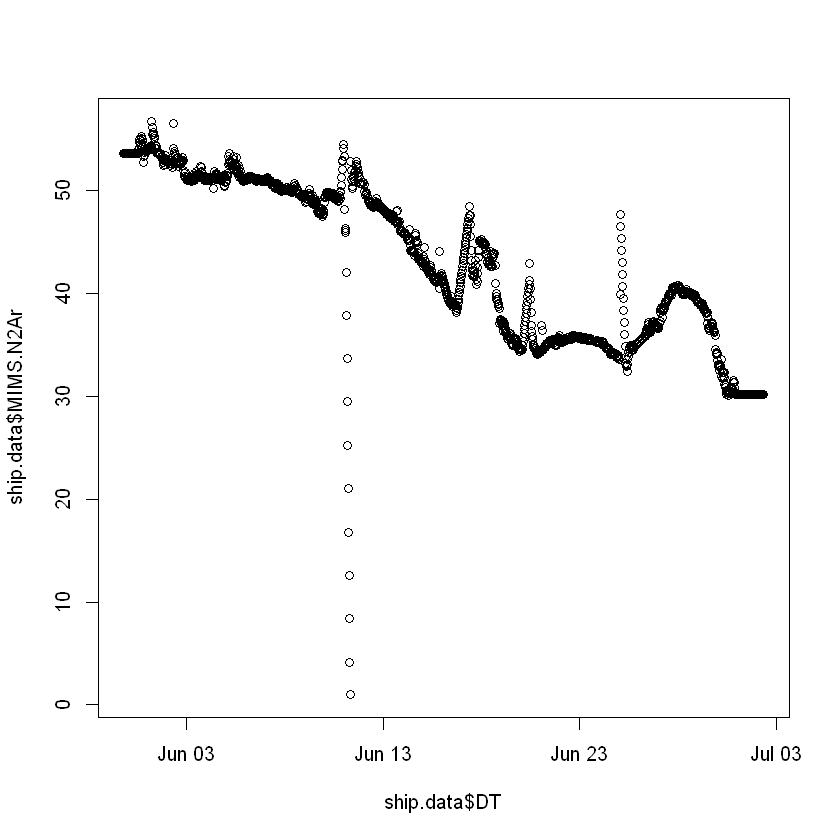

In [105]:
plot(ship.data$DT, ship.data$MIMS.N2Ar)
plot(ship.data$DT, ship.data$EIMS)